In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

# Import Numpy
import numpy as np
# For timer
import time
# Import OS
import os

# ==== LOCAL LIBS ====
import ecg_tools_lite as et
import evaluator as eva
import trainer as tr
import models as mod

# Summary-like from Tensorflow
from torchsummary import summary

In [2]:
# What are you trying to do?
create_new_model = True
create_new_res = True


# If create_new_model is True, epochs must have a value
epochs = 10

# If create_new_model is False, load_model_name must have a value
load_model_name = 'model_2021-3-13_1745.pt'
ecg_saved_res = 'res_pt_full.npy'


# Normalization option (either option 0 or 1)
norm_option = 2

In [3]:
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_e06.npy')).cuda().double()
ecg_clean = torch.from_numpy(np.load('all_none_fs1024_e24.npy')).cuda().double()

# Acquire original shape
x = ecg_noisy.shape[0]
y = ecg_noisy.shape[2]
z = ecg_noisy.shape[1]

# Reshape
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_clean = torch.reshape( ecg_clean, (x, y, z))

print(f'New shape: {ecg_noisy.shape}')

# == Basic Normalization technique (norm from 0 to 1)
# ecg_noisy = et.norm_basic( ecg_noisy )
# ecg_clean = et.norm_basic( ecg_clean )

# == Normalization technique (Norm from -1 to 1)
ecg_noisy = et.norm_sig( ecg_noisy )
ecg_clean = et.norm_sig( ecg_clean )

# ecg_noisy = ecg_noisy.cpu().numpy().flatten()
# ecg_clean = ecg_clean.cpu().numpy().flatten()

# ecg_noisy = et.realign_all_chunks(ecg_noisy, ecg_clean)

New shape: torch.Size([5544, 1, 1024])


In [4]:
kernel_size=kernel_size = 19
pad_size = 9
class cnn_denoiser(nn.Module):    
    def __init__(self):
        super(cnn_denoiser, self).__init__()

        self.denoiser = nn.Sequential(
            nn.Conv1d(1, 36, kernel_size=kernel_size, stride=1, padding=pad_size),
            nn.BatchNorm1d(36),
            nn.ReLU(True),
            # nn.AvgPool1d(kernel_size=2, stride=4),

            nn.Conv1d(36, 36, kernel_size=kernel_size, stride=1, padding=pad_size),
            nn.BatchNorm1d(36),
            nn.ReLU(True),
            # nn.AvgPool1d(kernel_size=2, stride=4),

            nn.Conv1d(36, 36, kernel_size=kernel_size, stride=1, padding=pad_size),
            nn.BatchNorm1d(36),
            nn.ReLU(True),
            # nn.AvgPool1d(kernel_size=2, stride=4),

            nn.Conv1d(36, 36, kernel_size=kernel_size, stride=1, padding=pad_size),
            nn.BatchNorm1d(36),
            nn.ReLU(True),
            # nn.AvgPool1d(kernel_size=2, stride=4),

            nn.Conv1d(36, 36, kernel_size=kernel_size, stride=1, padding=pad_size),
            nn.BatchNorm1d(36),
            nn.ReLU(True),
            # nn.AvgPool1d(kernel_size=2, stride=4),

            nn.Conv1d(36, 36, kernel_size=kernel_size, stride=1, padding=pad_size),
            nn.BatchNorm1d(36),
            nn.ReLU(True),
            # nn.AvgPool1d(kernel_size=2, stride=4),

            nn.Linear(1024, 1024)
        )

    def forward(self, x):
        x = self.denoiser(x)
        return x

In [5]:
summary( cnn_denoiser(), (1, 1024))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 36, 1024]            --
|    └─Conv1d: 2-1                       [-1, 36, 1024]            720
|    └─BatchNorm1d: 2-2                  [-1, 36, 1024]            72
|    └─ReLU: 2-3                         [-1, 36, 1024]            --
|    └─Conv1d: 2-4                       [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-5                  [-1, 36, 1024]            72
|    └─ReLU: 2-6                         [-1, 36, 1024]            --
|    └─Conv1d: 2-7                       [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-8                  [-1, 36, 1024]            72
|    └─ReLU: 2-9                         [-1, 36, 1024]            --
|    └─Conv1d: 2-10                      [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-11                 [-1, 36, 1024]            72
|    └─ReLU: 2-12                        [-1, 36, 1024]            --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 36, 1024]            --
|    └─Conv1d: 2-1                       [-1, 36, 1024]            720
|    └─BatchNorm1d: 2-2                  [-1, 36, 1024]            72
|    └─ReLU: 2-3                         [-1, 36, 1024]            --
|    └─Conv1d: 2-4                       [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-5                  [-1, 36, 1024]            72
|    └─ReLU: 2-6                         [-1, 36, 1024]            --
|    └─Conv1d: 2-7                       [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-8                  [-1, 36, 1024]            72
|    └─ReLU: 2-9                         [-1, 36, 1024]            --
|    └─Conv1d: 2-10                      [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-11                 [-1, 36, 1024]            72
|    └─ReLU: 2-12                        [-1, 36, 1024]            --
| 

In [6]:
# kernel_size=kernel_size = 16
# # pad_size = 9
# class cnn_denoiser(nn.Module):
#     def __init__(self):
#         super(cnn_denoiser, self).__init__()

#         self.denoiser = nn.Sequential(
#             nn.Conv1d(1, 40, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(40),
#             nn.Conv1d(40, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(20),
#             nn.Conv1d(20, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(20),
#             nn.Conv1d(20, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(20),
#             nn.Conv1d(20, 40, kernel_size, stride=2, padding=8 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(40),
#             nn.Conv1d(40, 1, kernel_size, stride=1, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(1),
#             nn.ConvTranspose1d(1, 40, kernel_size, stride=1, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(40),
#             nn.ConvTranspose1d(40, 20, kernel_size, stride=2, padding=8 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(20),
#             nn.ConvTranspose1d(20, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(20),
#             nn.ConvTranspose1d(20, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(20),
#             nn.ConvTranspose1d(20, 40, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(40),
#             nn.ConvTranspose1d(40, 1, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
#             nn.BatchNorm1d(1),
#             nn.Linear(1024, 1024), nn.ELU(True),
#             nn.Linear(1024, 1024), nn.ELU(True),
#             # nn.Linear(1, 1), nn.ELU(True)
#             # nn.ConvTranspose1d(1, 1, kernel_size, stride=1, padding=8 ), nn.ELU(True), # 521
#             # nn.BatchNorm1d(1),
#             # nn.ConvTranspose1d(1, 1, kernel_size, stride=1, padding=7 ), nn.ELU(True), # 521
#             # nn.BatchNorm1d(1),
#         )

#     def forward(self, x):
#         x = self.denoiser(x)

#         return x

In [7]:
# Train a new model
if create_new_model:
    # move model to be run by gpu
    model = cnn_denoiser().cuda()
    model.double()
    # start training the model
    losses = tr.train_model( model=model,
                    epochs=epochs, 
                    ecg_noisy=ecg_noisy, 
                    ecg_clean=ecg_clean,
                    train_pct=0.8)
    save_file_name = 'model_' + str(et.get_local_time()) + '.pt';
    # saved model will have model_YYYY-MM-DD_hhmm.pt format
    torch.save(model.state_dict(), save_file_name)
    print(f'Saved {et.get_local_time()}')

# load model instead if existing
else:
    print( "Model loaded")
    model = cnn_denoiser().cuda()
    model.double()
    model.load_state_dict(torch.load(load_model_name))
    model.to('cuda')
    model.eval()
    print( f'Model {load_model_name} has been loaded')

train_size[4435] + valid_size[1109]= 5544
same size
C:\python\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 1, 1024])) that is different to the input size (torch.Size([1, 36, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1 of 10 || time: 100.51 || loss = 0.11896077297434417
Epoch 2 of 10 || time: 96.95 || loss = 0.07581185994914891
Epoch 3 of 10 || time: 95.19 || loss = 0.06401028282478462
Epoch 4 of 10 || time: 95.30 || loss = 0.056686385509634125
Epoch 5 of 10 || time: 95.81 || loss = 0.051342948903906116
Epoch 6 of 10 || time: 95.72 || loss = 0.047764151676747385
Epoch 7 of 10 || time: 95.68 || loss = 0.04529046431903484
Epoch 8 of 10 || time: 95.74 || loss = 0.0431164783421416
Epoch 9 of 10 || time: 100.30 || loss = 0.04170918682097786
Epoch 10 of 10 || time: 103.69 || loss = 0.03940549708287495
Elaps

In [8]:
summary( cnn_denoiser(), (1, 1024))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 36, 1024]            --
|    └─Conv1d: 2-1                       [-1, 36, 1024]            720
|    └─BatchNorm1d: 2-2                  [-1, 36, 1024]            72
|    └─ReLU: 2-3                         [-1, 36, 1024]            --
|    └─Conv1d: 2-4                       [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-5                  [-1, 36, 1024]            72
|    └─ReLU: 2-6                         [-1, 36, 1024]            --
|    └─Conv1d: 2-7                       [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-8                  [-1, 36, 1024]            72
|    └─ReLU: 2-9                         [-1, 36, 1024]            --
|    └─Conv1d: 2-10                      [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-11                 [-1, 36, 1024]            72
|    └─ReLU: 2-12                        [-1, 36, 1024]            --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 36, 1024]            --
|    └─Conv1d: 2-1                       [-1, 36, 1024]            720
|    └─BatchNorm1d: 2-2                  [-1, 36, 1024]            72
|    └─ReLU: 2-3                         [-1, 36, 1024]            --
|    └─Conv1d: 2-4                       [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-5                  [-1, 36, 1024]            72
|    └─ReLU: 2-6                         [-1, 36, 1024]            --
|    └─Conv1d: 2-7                       [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-8                  [-1, 36, 1024]            72
|    └─ReLU: 2-9                         [-1, 36, 1024]            --
|    └─Conv1d: 2-10                      [-1, 36, 1024]            24,660
|    └─BatchNorm1d: 2-11                 [-1, 36, 1024]            72
|    └─ReLU: 2-12                        [-1, 36, 1024]            --
| 

In [9]:
ecg_res = model.denoiser(ecg_noisy[0:200])
print( f'ecg_res shape: {ecg_res.shape}')
ecg_res_flat = ecg_res.flatten()
print( f'ecg_res shape: {ecg_res_flat.shape}')

ecg_res shape: torch.Size([200, 36, 1024])
ecg_res shape: torch.Size([7372800])


torch.Size([10240])

<Figure size 1440x576 with 0 Axes>

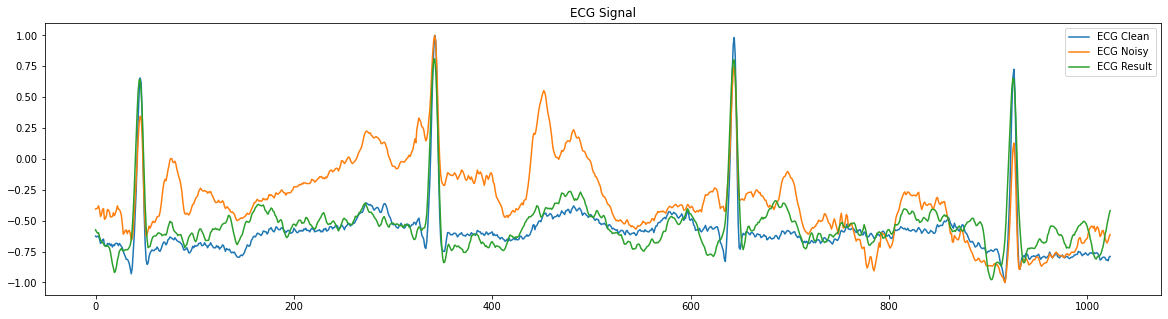

In [14]:
et.ecg_plot([ecg_clean.flatten().cpu(), ecg_noisy.flatten().cpu(), ecg_res_flat.detach().cpu()], ['ECG Clean', 'ECG Noisy', 'ECG Result'])

<Figure size 1440x576 with 0 Axes>

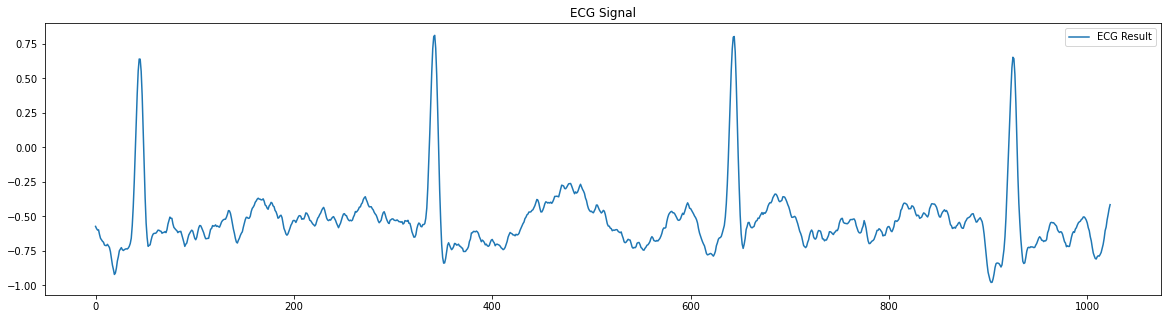

In [11]:
et.ecg_plot([ecg_res_flat.detach().cpu()], ['ECG Result'], index=1)

In [12]:
# train_pct = 0.8
# def get_train_valid_sizes( ecg_clean ):
#     # valid_pct = 1 - train_pct # auto compute for the validation
#     # Compute for the sizes of training and validation
#     total_size = ecg_clean.shape[0]
#     train_size = int( (total_size) * train_pct )
#     valid_size = total_size - train_size
    
#     print( f'train_size[{train_size}] + valid_size[{valid_size}]= {total_size}')
#     if( (train_size+valid_size) == total_size):
#         print(f'same size')
#     else:
#         print(f'not same size')
#     return train_size, valid_size, total_size

# # CREATE THE TRAINDEX (TRAINING INDEX SETS)
# def create_index_loaders( ecg_clean ):
#     # Get train and validation set sizes
#     train_size, valid_size, total_size = get_train_valid_sizes(ecg_clean)    
#     # Well instead of having to randomize the data itself, why not the numbers used to index
#     index_set = np.arange(0, total_size)

#     # split the indexes used for training and validation
#     train_indexset, val_indexset = random_split( index_set, (train_size, valid_size))

#     # Create DataLoaders for the corresponding train and val sets
#     traindex_loader = DataLoader( train_indexset, shuffle=True, batch_size=1 )
#     validex_loader = DataLoader( val_indexset, shuffle=True, batch_size=1 )
#     return traindex_loader, validex_loader

In [13]:
traindex_loader, validex_loader = create_index_loaders( ecg_clean )

NameError: name 'create_index_loaders' is not defined

In [ ]:
# model = cnn_denoiser().cuda()
# model.double()

# for epoch in range(1):
#     running_loss = 0.0

#     for i, data in enumerate(traindex_loader):
#         index = data.numpy()[0]
#         clean_samp = ecg_clean[index]

#         clean_samp = clean_samp.view(1, clean_samp.shape[0], clean_samp.shape[1])
#         print(clean_samp.shape)
#         train_res = model( clean_samp )